In [1]:
# Import libraries

import pandas as pd
import numpy as np
print(__doc__)
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     random_projection)
import hdbscan
import seaborn as sns
%matplotlib inline
import matplotlib
from matplotlib import colors
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import pylab
from matplotlib import pyplot
from IPython.display import display, HTML
import glob
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import cross_val_score


Automatically created module for IPython interactive environment


/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read input files into dataframes 

transactions = pd.read_csv('./inputcompjour/transaction_data.csv', header=0)
demographics = pd.read_csv('./inputcompjour/hh_demographic.csv', header=0)
campaign_desc = pd.read_csv('./inputcompjour/campaign_desc.csv', header=0)
campaign_table = pd.read_csv('./inputcompjour/campaign_table.csv', header=0)
coupon = pd.read_csv('./inputcompjour/coupon.csv', header=0)
coupon_redempt = pd.read_csv('./inputcompjour/coupon_redempt.csv', header=0)
product = pd.read_csv('./inputcompjour/product.csv', header=0)
causal_data = pd.read_csv('./inputcompjour/causal_data.csv', header=0)

In [3]:
# Display some files

print "transactions:"
display(transactions.head())
print "demographics:"
HTML(demographics.head().to_html())

transactions:


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


demographics:


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [4]:
# Merge dataframes on household_key and drop useless features

merged_data = pd.merge(transactions,demographics, on='household_key', how='inner')
merged_data=merged_data.drop(['TRANS_TIME','DAY','WEEK_NO','BASKET_ID','PRODUCT_ID'], axis=1)

In [5]:
# Number of unique STORE_ID
len(np.unique(merged_data.STORE_ID)) 

354

In [6]:
# Transform strigs into numerical data

merged_data=merged_data.apply(LabelEncoder().fit_transform)
print merged_data.head()

   household_key  QUANTITY  SALES_VALUE  STORE_ID  RETAIL_DISC  COUPON_DISC  \
0            440         1          226       337         2047          355   
1            440         1          306       337         2004          355   
2            440         1          316       337         2047          355   
3            440         1          257       337         1945          355   
4            440         1           67       337         1965          355   

   COUPON_MATCH_DISC  AGE_DESC  MARITAL_STATUS_CODE  INCOME_DESC  \
0                 63         5                    1            0   
1                 63         5                    1            0   
2                 63         5                    1            0   
3                 63         5                    1            0   
4                 63         5                    1            0   

   HOMEOWNER_DESC  HH_COMP_DESC  HOUSEHOLD_SIZE_DESC  KID_CATEGORY_DESC  
0               0             3           

In [7]:
# Split data into training and testing sets. x is features, y is what we are trying to predict. 

train, test = train_test_split(merged_data, test_size = 0.999)
train_y=train['STORE_ID']
train_x=train.drop('STORE_ID',axis=1)
test_y=test['STORE_ID']
test_x=test.drop('STORE_ID',axis=1)
len(np.unique(train_y)) 

116

In [8]:
# Model training and evaluation

model = XGBClassifier(seed=27, learning_rate=0.5, n_estimators=100, objective = "multi:softmax")
model.fit(train_x, train_y)
print "done"

done


In [9]:
# Cross validation scores

scores = cross_val_score(model, train_x, train_y, cv=5)        
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/home/mad/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.41 (+/- 0.06)


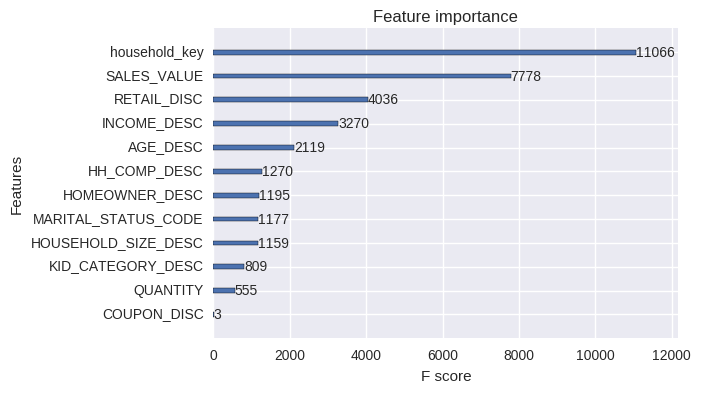

In [23]:
from xgboost import plot_importance
plot_importance(model)
pyplot.show()